# 4.3 - Probabilistic sampling of a sum of Gaussians#

*Andrew Valentine & Malcolm Sambridge - Research School of Earth Sciences, The Australian National University - Last updated Sept. 2019*

In this practical we will define a target PDF to be a mixture of three Gaussians

$$p(x,y) \propto \sum_{i=1}^3w_i \exp\left\{ -0.5 (\bar {\mathbf x}_i - {\mathbf x})^TC_i^{-1} (\bar {\mathbf x}_i - {\mathbf x})\right\}  $$

where the means, covariances and weights of the three distributions are given by, $\bar {\mathbf x}_1 = (0.6,0.6), \bar {\mathbf x}_2 = (0.8,0.2), \bar {\mathbf x}_3 = (0.2,0.3)$; $C_1 = 0.02I, C_2 = \left(\begin{array}
 0.1 & 0.08\\
0.08 & 0.1
\end{array}\right), C_3 = \left(\begin{array}
 0.1 & -0.06\\
-0.06 & 0.1
\end{array}\right) $, and $w_1 = 0.1, w_2 = 0.4, w_3 = 0.5$, respectively.

Load some plibraries

In [16]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import seaborn as sns

**Task 1:** Your first task to write a function to evaluate this PDF and then contour it over the region $0<= x,y <= 1)$. You should get a function that looks something lie the one below.

<img src="Figures/Gaussian3.png" alt="Slide" width="400"/>

In [5]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 

def make_thetas(xmin, xmax, n):
    xs = np.linspace(xmin, xmax, n)
    widths =(xs[1:] - xs[:-1])/2.0
    thetas = xs[:-1]+ widths
    return thetas

thetas1 = make_thetas(0, 1, 101)
thetas2 = make_thetas(0, 1, 101)
X, Y = np.meshgrid(thetas1, thetas2)

(100, 100, 2)


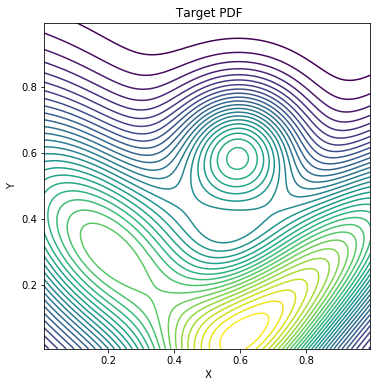

In [7]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 

def target(X,Y):
    x1,x2,x3 = np.array([0.6,0.6]),np.array([0.8,0.2]),np.array([0.2,0.3])
    cov1,cov2,cov3 = 0.02*np.eye(2), np.array([[0.1,0.08],[0.08,0.1]]), np.array([[0.1,-0.06],[-0.06,0.1]])
    p1 = multivariate_normal(x1,cov1)
    p2 = multivariate_normal(x2,cov2)
    p3 = multivariate_normal(x3,cov3)
    #print(np.shape(X))
    if(np.ndim(X) == 0): 
        #print('Ndim of X is zero')
        pos = [X,Y]
    else:
        pos = np.empty(X.shape + (2,))
        print(np.shape(pos))
        pos[:, :, 0] = X; pos[:, :, 1] = Y
    pdf = 0.1*p1.pdf(pos) + 0.4*p2.pdf(pos) + 0.5*p3.pdf(pos)
    return pdf

# draw contour map of target PDF

pdf = target(X,Y)

fig, ax = plt.subplots(1,1, subplot_kw=dict(aspect='equal'), figsize=(6,6))
ax.contour(X, Y, pdf,40)
plt.title(' Target PDF')
plt.xlabel(' X')
plt.ylabel('Y')
plt.show()

**Task 2:** Write a simple Metropolis McMC sampler to sample the target PDF . 


You could do this by implementing the following algorithm:
- Step 0. Generate a  starting point for a random walk ${\mathbf x} = (x_1,y_1)$ and calculate the value of the PDF $p( {\mathbf x}) $.
- Step 1. Generate a new position ${\mathbf x}^{\prime}$ as a random draw from a symmetric proposal distribution,
$q({\mathbf x}^{\prime}|{\mathbf x}) $. There is flexibility in choosing the form of this proposal distribution. 
Try using $q({\mathbf x}^{\prime}|{\mathbf x}) = N({\mathbf x}, \sigma^2I$), where $\sigma$ is some distance you choose, e.g. $\sigma=0.05$.
- Step 2. Evaluate the target PDF at the proposed location $p({\mathbf x}^{\prime})$.
- Step 3. Generate $r$ as a random draw from $U[0,1]$. If $r < \frac{p({\mathbf x}^{\prime})}{p({\mathbf x})}$ accept the random step by setting ${\mathbf x} = {\mathbf x}^{\prime}$; Otherwise discard ${\mathbf x}^{\prime}$.
- Step 4. Record ${\mathbf x}$ as an entry of your output ensemble and go to 1.

Use your Metropolis sampler to generate an ensemble of $N$ points, where you choose $N$, and compare them to a contour plot of the target PDF, $p({\mathbf x})$. What is the ratio of the number of proposals to the number of acceptances in your McMC waler? Does the density of samples reflect the target distribution?

You should get something like the figure below which was generated with the seaborn library.

<img src="Figures/walk_heat_map.png" alt="Slide" width="800"/>

In [9]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 

def inside(x): 
    return (x[0] < 1.0 and x[0] > 0. and x[1] > 0. and x[1] < 1.)

# draw samples  of target PDF

def McMCSampler(nsteps,start,sig): # McMC random walk of nsteps, starting at start using Gaussian proposal with width=sig
    x,L = np.zeros((nsteps+1,2)),np.zeros((nsteps+1))
    x[0] = start  # starting pint of random walk
    covq = sig*sig*np.eye(2)
    L[0] = target(x[0,0],x[0,1])
    q = multivariate_normal([0.0, 0.0],covq) # proposal distribution
    k = 0
    for step in range(nsteps): # loop over McMC steps
        xnew = x[step] + q.rvs() # proposed step position
        Lp = target(xnew[0],xnew[1]) # target distribution value at proposed position
        r = np.random.uniform() # random decision variable
        #print(step,L[step],Lp,r)
        if ( np.log(Lp)-np.log(L[step]) > np.log(r) and inside(xnew)): # accept proposed new position
            #print(' accept', np.log(Lp)-np.log(L[step]),np.log(r))
            L[step+1] = Lp
            x[step+1] = xnew
            k+=1
        else: # reject proposed new position
        #print(' reject')
            L[step+1] = L[step]
            x[step+1] = x[step]
    return x,L,100*k/nsteps # retrun path of random walk, target PDF values and percentage of accepted steps
    
nsteps = 10000 # Number of iterations
np.random.seed(1234)
xstart = np.array([ 0.2, 0.2])  # starting pint of random walk
qsig = 0.05# variance of random walk
x,L,e = McMCSampler(nsteps,xstart,qsig)
print(' Accept ratio of Metropolis = ',e,'%')

 Accept ratio of Metropolis =  88.44 %


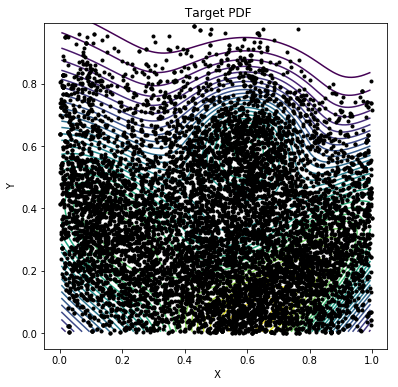

In [10]:
# plot random walk

fig, ax = plt.subplots(1,1, subplot_kw=dict(aspect='equal'), figsize=(12,6))
ax.contour(X, Y, pdf,40)
ax.set_title(' Target PDF')
ax.plot(x.T[0],x.T[1],'k.')
ax.set_xlabel(' X')
ax.set_ylabel('Y')

plt.show()

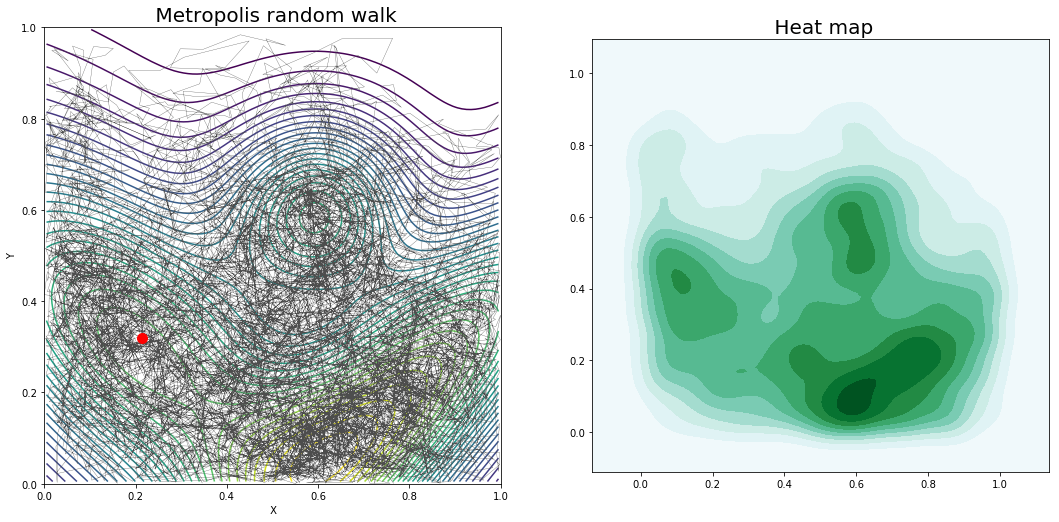

In [11]:
import seaborn as sns; 
#sns.set(style="white",color_codes=True)
# final whole walk
fig, ax = plt.subplots(1,2, subplot_kw=dict(aspect='equal'), figsize=(18,9))
ax[0].contour(X, Y, pdf,40,color='viridis')
ax[0].set_title(' Metropolis random walk',size=20)
ax[0].plot(x.T[0],x.T[1],'-',color='0.3',linewidth=0.3)
ax[0].plot(x[-1].T[0],x[-1].T[1],'ro',markersize=10)
ax[0].set_xlabel(' X')
ax[0].set_ylabel('Y')
ax[0].set_xlim(0.0,1.0)
ax[0].set_ylim(0.0,1.0)
#g = sns.jointplot(x.T[0],x.T[1],kind="kde", space=0, color='r',ax=ax[1])
ax[1].set_title(' Heat map',size=20)
ax[1] = sns.kdeplot(x.T[0], x.T[1], shade=True,color="b")
#plt.savefig('randomwalk_all.png',format='PNG')
plt.show()

**Task 3** Compare your samples to the original by plotting 1-D and 2-D marginal distributions for $x$ and $y$. You may find using the seaborn library very useful for this task.


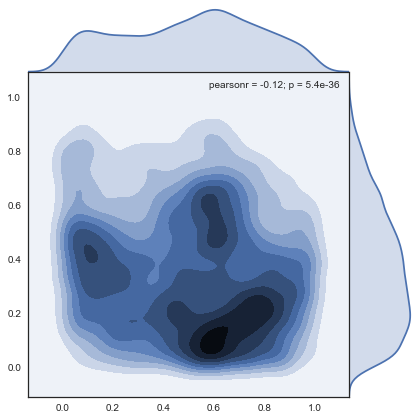

In [12]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 

import seaborn as sns; 
sns.set(style="white",color_codes=True)

# use seaborn to plot density of samples together with marginals

g = sns.jointplot(x.T[0],x.T[1],kind="kde", space=0, color="b")
plt.show()

**Task 4:** Change the proposal distribution by increasing or decreasing $\sigma$. What do you notice about the acceptance ratio and the distribution of samples?

In [14]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 

nsteps = 10000 # Number of iterations
np.random.seed(1234)
xstart = np.array([ 0.2, 0.2])  # starting pint of random walk
qsig = 0.001# variance of random walk
x,L,e = McMCSampler(nsteps,xstart,qsig)
print(' Accept ratio of Metropolis = ',e)

 Accept ratio of Metropolis =  99.98
 Acceptance ratio goes up if sigma is decreased and vice versa


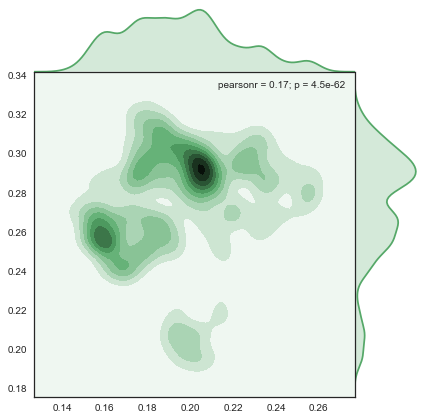

In [15]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 

g = sns.jointplot(x.T[0],x.T[1],kind="kde", space=0, color="g")

#g = (sns.jointplot(x.T[0],x.T[1], color="k").plot_joint(sns.kdeplot, zorder=0, n_levels=6))
plt.show()


** Conclusion: ** Increasing the proposal distribution width decreases the acceptance ratio of the random walk, while decreasing it increases the acceptance ratio, but more steps are required to explore the space. Plotting random walk samples becomes less useful as the number increase because it is all black. Calculating densities and marginals with seabon library allows one to view the densities better.